Tutorial 6: More Ray Tracing
============================

In this example, we'll reinforce what we learnt about ray-tracing in the last tutorial and introduce the following
new concepts:

1) That a `Tracer` can be given any number of galaxies.

2) That by specifying redshifts and a cosmology, our results are converted to physical unit_label of
kiloparsecs (kpc).

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt

from astropy import cosmology

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


To begin, lets setup the `Grid2D`'s we'll ray-trace using. Lets do something crazy, and use a higher resolution `Grid2D` 
then before and set the sub `Grid2D` size to 4x4 per pixel!

Every pixel is sub-gridded by 4x4, so the sub-grid has x16 more coordinates.

Lets also stop calling it the `image_plane_grid`, and just remember from now on our `grid` is in the image-plane.

In [2]:
grid = al.Grid2D.uniform(shape_native=(200, 200), pixel_scales=0.025, sub_size=2)

Every pixel is sub-gridded by 4x4, so the sub-grid has x16 more coordinates.

In [3]:
print(grid.sub_shape_native)
print(grid.sub_shape_slim)

(400, 400)
160000


Next, lets setup a lens galaxy. In the previous tutorial, we set up each `Profile` one line at a time. This made code 
long and cumbersome to read. This time we'll setup easy galaxy using one block of code. 
 

we'll also give the lens galaxy some attributes we didn`t in the last tutorial:

 1) A `LightProfile`, meaning its light will appear in the image.
 2) An external shear, which accounts for the deflection of light due to line-of-sight structures.
 3) A redshift, which the `Tracer` will use to convert arc second coordinates to kpc.

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.SphericalSersic(
        centre=(0.0, 0.0), intensity=2.0, effective_radius=0.5, sersic_index=2.5
    ),
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.0, -0.111111), einstein_radius=1.6
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.0)),
)

print(lens_galaxy)

Redshift: 0.5
Light Profiles:
SphericalSersic
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 2.0
effective_radius: 0.5
sersic_index: 2.5
Mass Profiles:
EllipticalIsothermal
centre: (0.0, 0.0)
elliptical_comps: (0.0, -0.111111)
axis_ratio: 0.800000180000018
phi: 90.0
einstein_radius: 1.6
slope: 2.0
core_radius: 0.0
ExternalShear
centre: (0.0, 0.0)
elliptical_comps: (0.05, 0.0)
axis_ratio: 0.9047619047619047
phi: 45.0
magnitude: 0.05


Lets also create a small satellite galaxy nearby the lens galaxy and at the same redshift.

In [5]:
lens_satellite = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.SphericalDevVaucouleurs(
        centre=(1.0, 0.0), intensity=2.0, effective_radius=0.2
    ),
    mass=al.mp.SphericalIsothermal(centre=(1.0, 0.0), einstein_radius=0.4),
)

print(lens_satellite)

Redshift: 0.5
Light Profiles:
SphericalDevVaucouleurs
centre: (1.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 2.0
effective_radius: 0.2
sersic_index: 4.0
Mass Profiles:
SphericalIsothermal
centre: (1.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
einstein_radius: 0.4
slope: 2.0
core_radius: 0.0


Lets have a quick look at the appearance of our lens galaxy and its satellite.

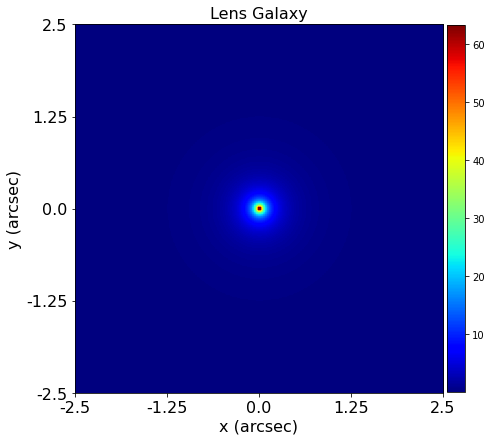

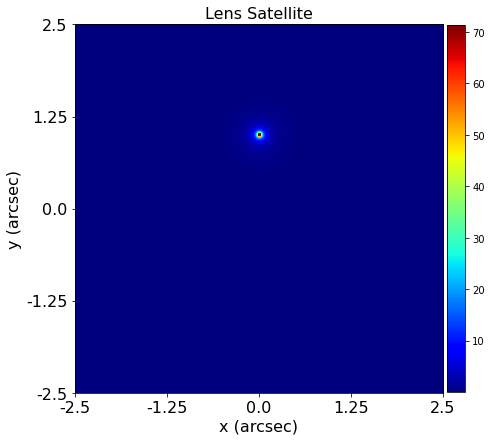

In [6]:
mat_plot_2d = aplt.MatPlot2D(title=aplt.Title(label="Lens Galaxy"))

galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=lens_galaxy, grid=grid, mat_plot_2d=mat_plot_2d
)
galaxy_plotter.figures(image=True)

mat_plot_2d = aplt.MatPlot2D(title=aplt.Title(label="Lens Satellite"))

galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=lens_satellite, grid=grid, mat_plot_2d=mat_plot_2d
)
galaxy_plotter.figures(image=True)

And their deflection angles - note that the satellite doesn`t contribute as much to the deflections.

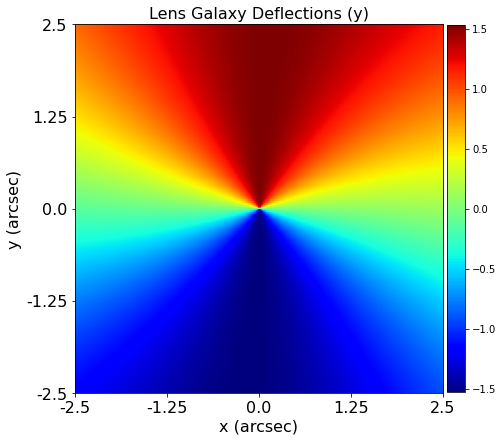

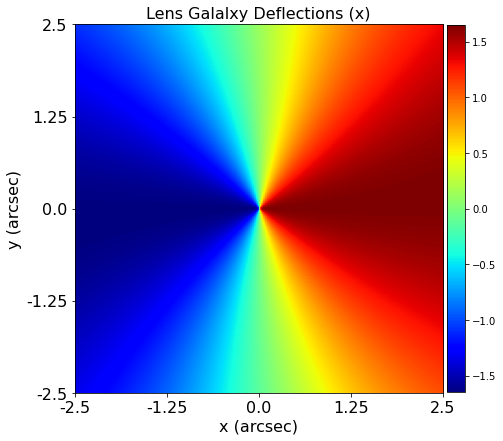

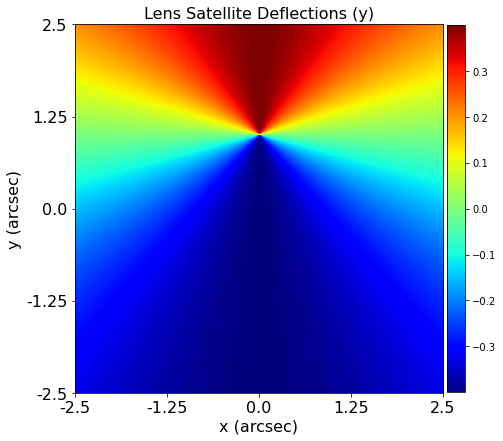

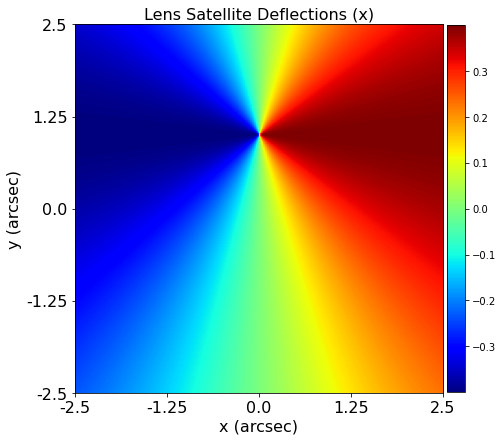

In [7]:
mat_plot_2d = aplt.MatPlot2D(title=aplt.Title(label="Lens Galaxy Deflections (y)"))

galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=lens_galaxy, grid=grid, mat_plot_2d=mat_plot_2d
)
galaxy_plotter.figures(deflections_y=True)

# NOTE: It would be annoying to have to reset the title for every plot using the following code:

# mat_plot_2d = aplt.MatPlot2D(
#     title=aplt.Title(label="Lens Galalxy Deflections (x)")
# )
# galaxy_plotter = aplt.GalaxyPlotter(galaxy=lens_galaxy, grid=grid, mat_plot_2d=mat_plot_2d)

# We can set the title more conveniently as follows:

galaxy_plotter.set_title("Lens Galalxy Deflections (x)")
galaxy_plotter.figures(deflections_x=True)

galaxy_plotter = aplt.GalaxyPlotter(galaxy=lens_satellite, grid=grid)
galaxy_plotter.set_title("Lens Satellite Deflections (y)")
galaxy_plotter.figures(deflections_y=True)
galaxy_plotter.set_title("Lens Satellite Deflections (x)")
galaxy_plotter.figures(deflections_x=True)

Now, lets make two source galaxies at redshift 1.0. Lets not use the terms `light` and `mass` to setup the light and 
`MassProfile`'s. Instead, lets use more descriptive names of what we think each component represents ( e.g. a `bulge` 
and `disk`).

In [8]:
source_galaxy_0 = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.SphericalDevVaucouleurs(
        centre=(0.1, 0.2), intensity=0.3, effective_radius=0.3
    ),
    disk=al.lp.EllipticalExponential(
        centre=(0.1, 0.2),
        elliptical_comps=(0.111111, 0.0),
        intensity=3.0,
        effective_radius=2.0,
    ),
)

source_galaxy_1 = al.Galaxy(
    redshift=1.0,
    disk=al.lp.EllipticalExponential(
        centre=(-0.3, -0.5),
        elliptical_comps=(0.1, 0.0),
        intensity=8.0,
        effective_radius=1.0,
    ),
)

print(source_galaxy_0)
print(source_galaxy_1)

Redshift: 1.0
Light Profiles:
SphericalDevVaucouleurs
centre: (0.1, 0.2)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 0.3
effective_radius: 0.3
sersic_index: 4.0
EllipticalExponential
centre: (0.1, 0.2)
elliptical_comps: (0.111111, 0.0)
axis_ratio: 0.800000180000018
phi: 45.0
intensity: 3.0
effective_radius: 2.0
sersic_index: 1.0
Redshift: 1.0
Light Profiles:
EllipticalExponential
centre: (-0.3, -0.5)
elliptical_comps: (0.1, 0.0)
axis_ratio: 0.8181818181818181
phi: 45.0
intensity: 8.0
effective_radius: 1.0
sersic_index: 1.0


Lets look at our source galaxies (before lensing)

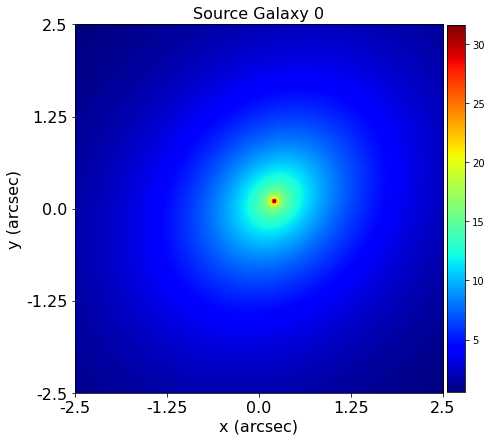

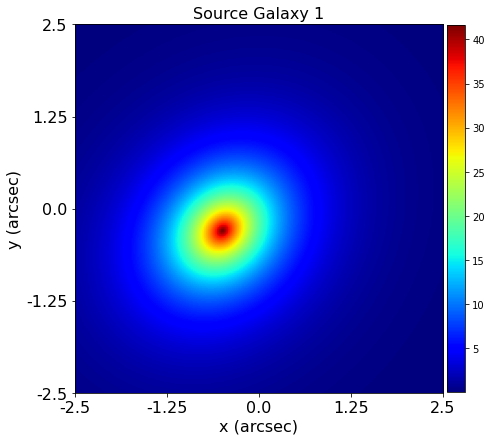

In [9]:
galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=source_galaxy_0, grid=grid, mat_plot_2d=mat_plot_2d
)
galaxy_plotter.set_title("Source Galaxy 0")
galaxy_plotter.figures(image=True)

galaxy_plotter = aplt.GalaxyPlotter(galaxy=source_galaxy_1, grid=grid)
galaxy_plotter.set_title("Source Galaxy 1")
galaxy_plotter.figures(image=True)

Now lets pass our 4 galaxies to the ray_tracing module, which means the following will occur:

 1) Using the galaxy redshift`s, and image-plane and source-plane will be created with the appopriate galaxies.

Note that we've also supplied the `Tracer` below with a Planck15 cosmology.

In [10]:
tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy, lens_satellite, source_galaxy_0, source_galaxy_1],
    cosmology=cosmology.Planck15,
)

We can next plot the tracer`s `Profile` image, which is compute as follows:

 1) First, using the image-plane `Grid2D`, the images of the lens galaxy and its satellite are computed.

 2) Using the `MassProfile`'s of the lens and satellite, their deflection angles are computed.

 3) These deflection angles are summed, such that the deflection of light due to every `MassProfile` and both the lens 
 galaxy and its satellite is computed.

 4) These deflection angles are used to trace every image-grid coordinate to a source-plane coordinate.

 5) The image of the source galaxies is computed by ray-tracing their light back to the image-plane.

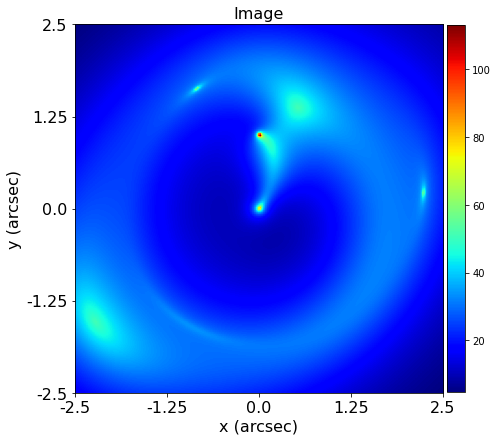

In [11]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.set_title("Image")
tracer_plotter.figures(image=True)

As we did previously, we can plot the `Grid2D` of the source plane and inspect the source-plane grid.

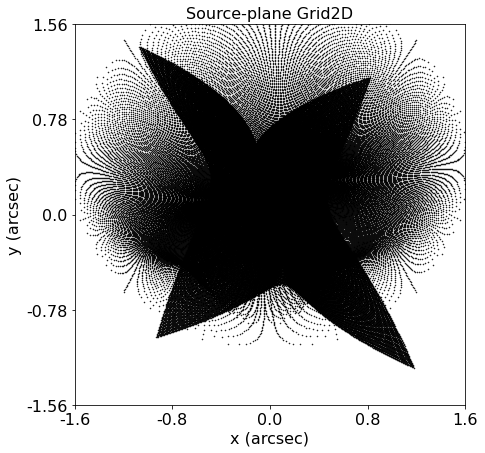

In [12]:
tracer_plotter.set_title("Source-plane Grid2D")
tracer_plotter.figures_2d_of_planes(plane_grid=True, plane_index=1)

We can zoom in on the `centre` of the source-plane.

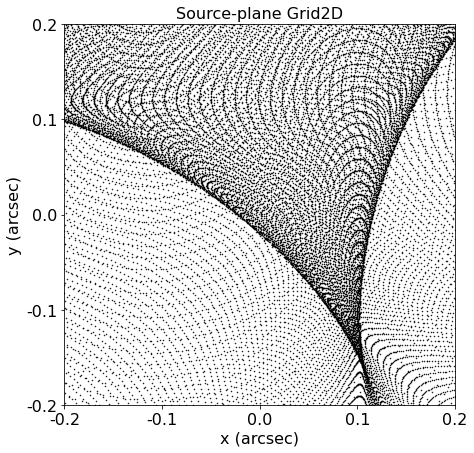

In [13]:
mat_plot_2d = aplt.MatPlot2D(axis=aplt.Axis(extent=[-0.2, 0.2, -0.2, 0.2]))

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.set_title("Source-plane Grid2D")
tracer_plotter.figures_2d_of_planes(plane_grid=True, plane_index=1)

Lets plot the lensing quantities again. Note that, because we supplied our galaxies with redshifts and our `Tracer` with 
a cosmology, our unit can be converted to kiloparsecs! (This cell can take a bit of time to run)

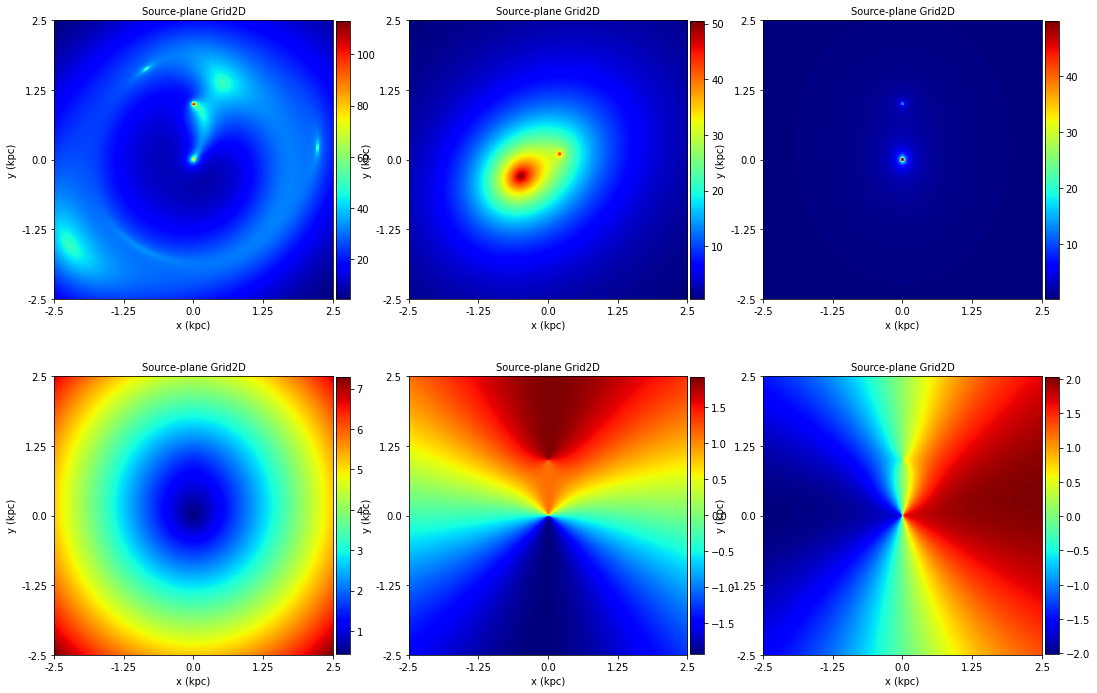

In [14]:
mat_plot_2d = aplt.MatPlot2D(units=aplt.Units(in_kpc=True))

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.subplot_tracer()

In the previous example, we saw that the `Tracer` had attributes we plotted (e.g. convergence, potential, etc.). Now 
we've input an **AstroPy** cosmology and galaxy redshifts, the `Tracer` has attributes associated with its cosmology.

We can use the `cosmology_util` module in **PyAutoLens** to compute quantities associated with this cosmology.

In [15]:
cosmology = tracer.cosmology

print("Image-plane arcsec-per-kpc:")
print(al.util.cosmology.arcsec_per_kpc_from(redshift=0.5, cosmology=cosmology))
print("Image-plane kpc-per-arcsec:")
print(al.util.cosmology.kpc_per_arcsec_from(redshift=0.5, cosmology=cosmology))
print("Angular Diameter Distance to Image-plane (kpc):")
print(
    al.util.cosmology.angular_diameter_distance_to_earth_in_kpc_from(
        redshift=0.5, cosmology=cosmology
    )
)

print("Source-plane arcsec-per-kpc:")
print(al.util.cosmology.arcsec_per_kpc_from(redshift=1.0, cosmology=cosmology))
print("Source-plane kpc-per-arcsec:")
print(al.util.cosmology.kpc_per_arcsec_from(redshift=1.0, cosmology=cosmology))
print("Angular Diameter Distance to Source-plane:")
print(
    al.util.cosmology.angular_diameter_distance_to_earth_in_kpc_from(
        redshift=1.0, cosmology=cosmology
    )
)

print("Angular Diameter Distance From Image To Source Plane:")
print(
    al.util.cosmology.angular_diameter_distance_between_redshifts_in_kpc_from(
        redshift_0=0.5, redshift_1=1.0, cosmology=cosmology
    )
)
print("Lensing Critical convergence:")
print(
    al.util.cosmology.critical_surface_density_between_redshifts_solar_mass_per_kpc2_from(
        redshift_0=0.5, redshift_1=1.0, cosmology=cosmology
    )
)

Image-plane arcsec-per-kpc:
0.1590272254082433
Image-plane kpc-per-arcsec:
6.288231448626936
Angular Diameter Distance to Image-plane (kpc):
1297040.8413879331
Source-plane arcsec-per-kpc:
0.12147853800264835
Source-plane kpc-per-arcsec:
8.231906774990978
Angular Diameter Distance to Source-plane:
1697952.655987674
Angular Diameter Distance From Image To Source Plane:
725172.0249467241
Lensing Critical convergence:
3001935359.3527756


And with that, we've completed tutorial 6. Try the following:

 1) By changing the lens and source galaxy redshifts, does the image of the `Tracer` change at all?

 2) What happens to the cosmological quantities as you change these redshifts? Do you remember enough of your 
    cosmology lectures to predict how quantities like the angular diameter distance change as a function of redshift?

 3) The `Tracer` has a small delay in being computed, whereas other tracers were almost instant. What do you think 
    is the cause of this slow-down?